<a href="https://colab.research.google.com/github/V3ness/CDS6344-SMC-Project-Repo/blob/main/SMC_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import kagglehub

# Download dataset from Kaggle
path1 = kagglehub.dataset_download("edenbd/150k-lyrics-labeled-with-spotify-valence")
path2 = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")

print("Path to dataset files:", path1)
print("Path to dataset files:", path2)

Path to dataset files: /kaggle/input/150k-lyrics-labeled-with-spotify-valence
Path to dataset files: /kaggle/input/ultimate-spotify-tracks-db


In [ ]:
# Import general purpose packages
import numpy as np
import pandas as pd
import sys
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# Import preprocessing packages
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Import ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Import transformers and PyTorch packages
import torch
from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

# Import deep learning packages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (TextVectorization, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv1D, GlobalMaxPooling1D)
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, InputLayer
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Reshape, Conv1D, GlobalMaxPooling1D,
    Dropout, Dense
)

# Reading Datasets

In [ ]:
root1 = input("Input path to 1st dataset files: ")
root2 = input("Input path to 2nd dataset files: ")

# Load spotify artist dataset with valence score but no Genre
# Replace the path if necessary
artist_valence_df = pd.read_csv(f'{root1.strip()}/labeled_lyrics_cleaned.csv')

# Load spotify artist dataset with Genre & other features
# Replace the path if necessary
spotify_df = pd.read_csv(f'{root2.strip()}/SpotifyFeatures.csv')
print("Dataset successfully read!")

Dataset successfully read!


# Combine data
To create a spotify music dataset with features like artist, lyrics, song title, valence, genre, and other interesting audio features, we combined both datasets with matching artist name and song name.

In [ ]:
combined_spotify_df = pd.merge(artist_valence_df, spotify_df, how="inner", left_on=("artist", "song"), right_on=("artist_name", "track_name"))

We will select the features we want to use to train a LLM model and classifies

In [ ]:
combined_spotify_df.columns

Index(['Unnamed: 0', 'artist', 'seq', 'song', 'label', 'genre', 'artist_name',
       'track_name', 'track_id', 'popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence'],
      dtype='object')

In [ ]:
combined_spotify_df = combined_spotify_df[['artist_name', 'seq', 'song', 'genre', 'popularity', 'danceability', 'energy', 'valence']]

In [ ]:
combined_spotify_df = combined_spotify_df.rename(columns={'seq': 'lyrics', 'song': 'song_name'})

# EDA

In [ ]:
combined_spotify_df.shape

(14337, 8)

In [ ]:
combined_spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist_name   14337 non-null  object 
 1   lyrics        14337 non-null  object 
 2   song_name     14337 non-null  object 
 3   genre         14337 non-null  object 
 4   popularity    14337 non-null  int64  
 5   danceability  14337 non-null  float64
 6   energy        14337 non-null  float64
 7   valence       14337 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 896.2+ KB


In [ ]:
combined_spotify_df.nunique()

In [ ]:
combined_spotify_df.describe()

,popularity,danceability,energy,valence
count,14337.000000,14337.000000,14337.000000,14337.000000
mean,50.485387,0.558580,0.652691,0.500165
std,13.054357,0.149918,0.225619,0.233931
min,0.000000,0.061700,0.007210,0.031700
25%,43.000000,0.457000,0.493000,0.316000
50%,51.000000,0.559000,0.685000,0.492000
75%,59.000000,0.664000,0.839000,0.681000
max,89.000000,0.971000,0.999000,0.987000


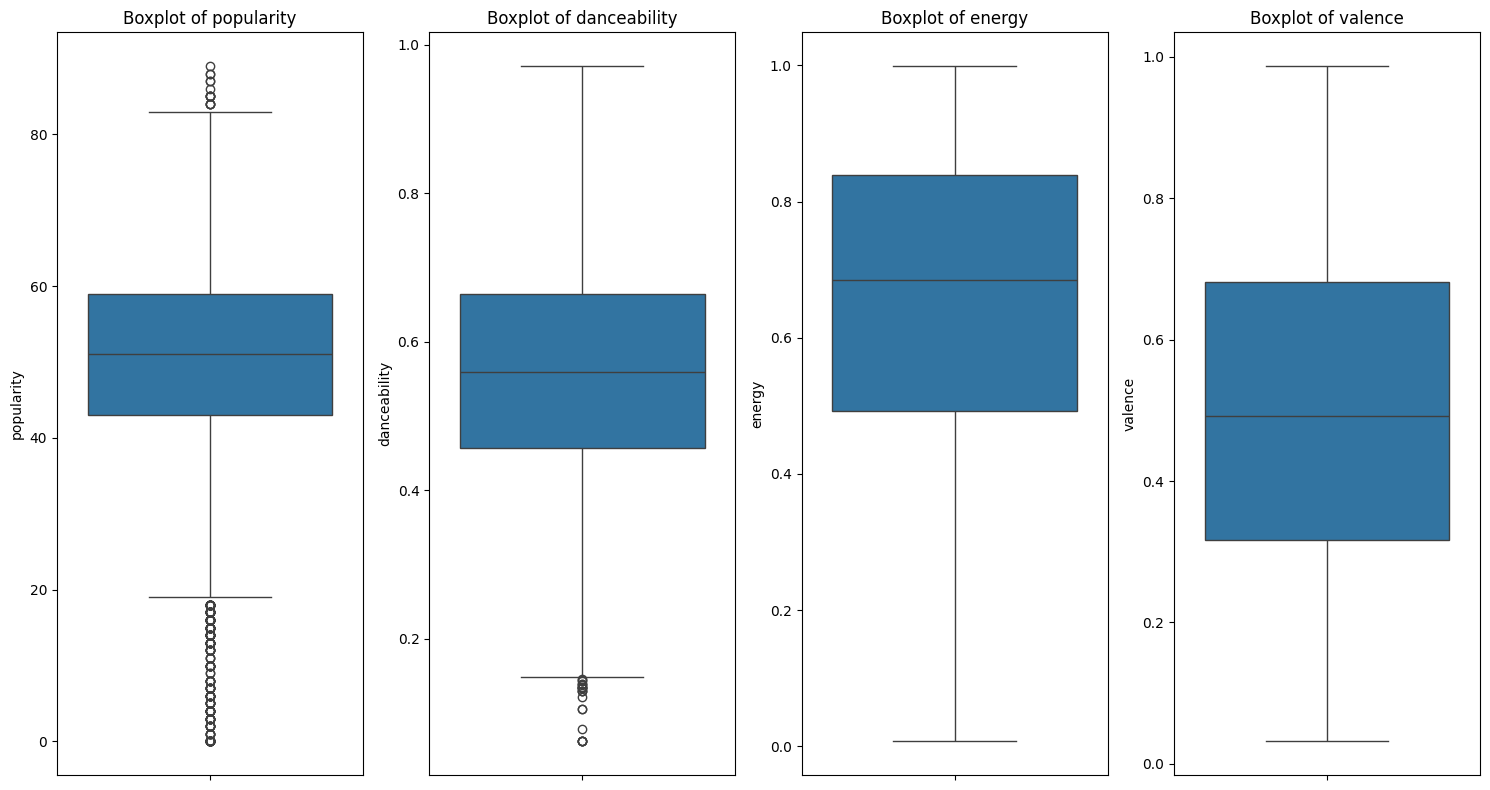

In [ ]:
# Select only numerical columns
numerical_cols = combined_spotify_df.select_dtypes(include=np.number).columns

# Create boxplots for all numerical columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=combined_spotify_df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Data Preprocessing (Text Processing)
In this section, we apply some text processing method to clean the lyrics as much as possible. Like removing new space, convert to small case, remove punctuations, etc.

In [ ]:
lyrics_df = combined_spotify_df['lyrics']
lyrics_list = list(lyrics_df.iloc[0:])

# Remove \n and \r in the lyrics
# Convert to small case
# Remove punctuations
for i, lyrics in enumerate(lyrics_list):
  lyrics_list[i] = " ".join(lyrics.splitlines())
  lyrics_list[i] = lyrics_list[i].replace("  ", " ")
  lyrics_list[i] = lyrics_list[i].casefold()
  lyrics_list[i] = re.sub(r'[^\w\s]', '', lyrics_list[i])
  lyrics_list[i] = re.sub('[^a-zA-Z0-9 ]', ' ', lyrics_list[i])
  lyrics_list[i] = lyrics_list[i].replace("_", " ")

lyrics_list[0]

'little bird little bird fly through my window little bird little bird fly through my window little bird little bird fly through my window find molasses candy through my window my sugar lump fly through my window my sugar lump find molasses candy who knows a bird me chickadee whats a chickadee say chchchchchch chickadee chickadee fly through my window chickadee chickadee fly through my window chickadee chickadee fly through my window find molasses candy through my window my sugar lump fly through my window my sugar lump and find molasses candy who knows another bird me jaybird what does a jaybird say jayjayjayjayjayjay jaybird jaybird fly through my window jaybird jaybird fly through my window jaybird jaybird fly through my window find molasses candy through my window my sugar lump fly through my window my sugar lump find molasses candy who knows one more bird i do a whippoorwill what does a whippoorwill say whippoorwill whippoorwill fly through my window whippoorwill whippoorwill fly 

### Tokenization

In [ ]:
nltk.download('punkt_tab')

word_tokenize = nltk.word_tokenize
tokenized_lyrics = [word_tokenize(lyric) for lyric in lyrics_list]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Stopwords Removal + Lemmatization

In [ ]:
# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# Remove not meaningful words
def is_valid_word(word):
    # Remove if repeated substrings
    if re.search(r'(\w{2,4})\1{2,}', word):
        return False
    # Remove if character repeated more than 3 times in a row
    if re.search(r'(.)\1{3,}', word):
        return False
    return True

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

processed_lyrics_tokenized = []
processed_lyrics_text = []

# Process each tokenized lyric
for tokens in tokenized_lyrics:
    filtered_tokens = []
    for word in tokens:
      if word not in stop_words and is_valid_word(word):
        filtered_tokens.append(lemmatizer.lemmatize(word))
    processed_lyrics_tokenized.append(filtered_tokens)
    processed_lyrics_text.append(" ".join(filtered_tokens))

# Example output
print("Tokenized:", processed_lyrics_tokenized[0])
print("Text:", processed_lyrics_text[0])

Tokenized: ['little', 'bird', 'little', 'bird', 'fly', 'window', 'little', 'bird', 'little', 'bird', 'fly', 'window', 'little', 'bird', 'little', 'bird', 'fly', 'window', 'find', 'molasses', 'candy', 'window', 'sugar', 'lump', 'fly', 'window', 'sugar', 'lump', 'find', 'molasses', 'candy', 'know', 'bird', 'chickadee', 'whats', 'chickadee', 'say', 'chickadee', 'chickadee', 'fly', 'window', 'chickadee', 'chickadee', 'fly', 'window', 'chickadee', 'chickadee', 'fly', 'window', 'find', 'molasses', 'candy', 'window', 'sugar', 'lump', 'fly', 'window', 'sugar', 'lump', 'find', 'molasses', 'candy', 'know', 'another', 'bird', 'jaybird', 'jaybird', 'say', 'jaybird', 'jaybird', 'fly', 'window', 'jaybird', 'jaybird', 'fly', 'window', 'jaybird', 'jaybird', 'fly', 'window', 'find', 'molasses', 'candy', 'window', 'sugar', 'lump', 'fly', 'window', 'sugar', 'lump', 'find', 'molasses', 'candy', 'know', 'one', 'bird', 'whippoorwill', 'whippoorwill', 'say', 'whippoorwill', 'whippoorwill', 'fly', 'window', '

In [ ]:
# Add to DataFrame
combined_spotify_df['preprocessed_lyrics_tokenized'] = processed_lyrics_tokenized
combined_spotify_df['preprocessed_lyrics'] = processed_lyrics_text

# Preview
combined_spotify_df[['lyrics', 'preprocessed_lyrics', 'preprocessed_lyrics_tokenized']].head()

,lyrics,preprocessed_lyrics,preprocessed_lyrics_tokenized
0,"Little bird, little bird\r\nFly through my win...",little bird little bird fly window little bird...,"[little, bird, little, bird, fly, window, litt..."
1,"I've got a friend in Baltimore, little Liza Ja...",ive got friend baltimore little liza jane stre...,"[ive, got, friend, baltimore, little, liza, ja..."
2,Who's my pretty baby\r\nWho's my pretty little...,who pretty baby who pretty little baby youre p...,"[who, pretty, baby, who, pretty, little, baby,..."
3,"Go to sleep, go to sleep\r\nGo to sleep you li...",go sleep go sleep go sleep little sleep eye go...,"[go, sleep, go, sleep, go, sleep, little, slee..."
4,"Not a word, from your lips\nYou just took for ...",word lip took granted want skinny dip quick hi...,"[word, lip, took, granted, want, skinny, dip, ..."


# Modeling

In this section, we will apply Machine Learning (ML) models, Deep Learning (DL) models, and Transformers on the dataset. We aim to build models to handle these tasks:
1. Predict sentiment labels from valence  (feature from dataset)
2. Generate the sentiment score
3. Predict sentiment score (feature from dataset)

## Building DL model and experiment with different settings.

## Experiment 1
- We build BiLSTM and CNN model to predict valence score.

In [ ]:
# Experiment 1

# Define sentiment labels from 'valence'
def label_from_valence(v):
    if v < 0.4:
        return 0   # Negative
    elif v <= 0.6:
        return 1   # Neutral
    else:
        return 2   # Positive

combined_spotify_df['sentiment_label'] = combined_spotify_df['valence'].apply(label_from_valence)
print(combined_spotify_df['sentiment_label'].value_counts())

sentiment_label
0    5369
2    5015
1    3953
Name: count, dtype: int64


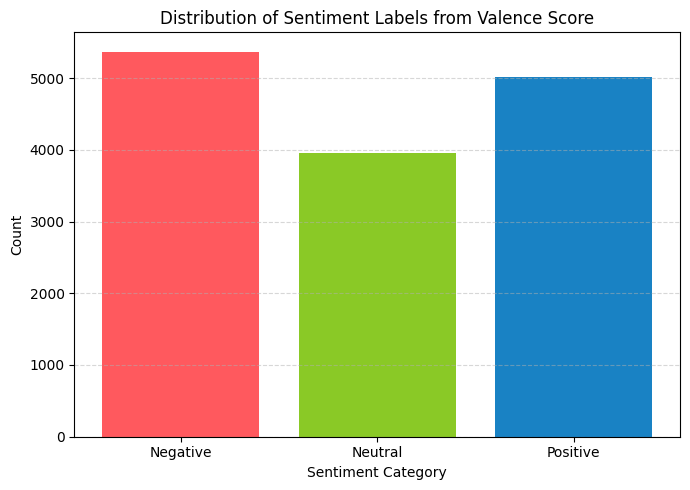

In [ ]:
# Get value counts (will be a Series)
sentiment_counts = combined_spotify_df['sentiment_label'].value_counts().sort_index()

# Map your labels
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
categories = [label_map[idx] for idx in sentiment_counts.index]
values = sentiment_counts.values

# Plot
plt.figure(figsize=(7, 5))
plt.bar(categories, values, color=['#FF595E', '#8AC926', '#1982C4'])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels from Valence Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Train/test split (80/20), stratified
X = combined_spotify_df['preprocessed_lyrics'].astype(str).tolist()
y = combined_spotify_df['sentiment_label'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#text vectorization
max_vocab_size = 20000
max_seq_len    = 100
embedding_dim  = 128

# (a) Create & adapt the vectorizer on training texts
vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_seq_len
)
vectorizer.adapt(X_train)    # X_train is list of raw preprocessed strings

# (b) Get the vocabulary size
vocab_size = vectorizer.vocabulary_size()
print(f"TextVectorization vocab size: {vocab_size}")

# (c) Prepare sequences (optional if you embed inside the model)
X_train_seq = vectorizer(np.array([[s] for s in X_train])).numpy().squeeze()
X_val_seq   = vectorizer(np.array([[s] for s in X_val])).numpy().squeeze()

TextVectorization vocab size: 20000


In [ ]:
# Build & compile BiLSTM with learned embeddings
bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train BiLSTM
history_bi1 = bilstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=128
)
bilstm.summary()

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4225 - loss: 1.0687 - val_accuracy: 0.5404 - val_loss: 0.9661
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6495 - loss: 0.8104 - val_accuracy: 0.6471 - val_loss: 0.8084
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8399 - loss: 0.4440 - val_accuracy: 0.6984 - val_loss: 0.7777
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9183 - loss: 0.2455 - val_accuracy: 0.7312 - val_loss: 0.8647
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9594 - loss: 0.1351 - val_accuracy: 0.7326 - val_loss: 0.8938


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,819 (32.32 MB)

 Trainable params: 2,823,939 (10.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,647,880 (21.54 MB)

In [ ]:
cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Train CNN
history_cnn1 = cnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=128
)
cnn.summary()

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3856 - loss: 1.0871 - val_accuracy: 0.5112 - val_loss: 1.0388
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5765 - loss: 0.9839 - val_accuracy: 0.6018 - val_loss: 0.9298
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7102 - loss: 0.7961 - val_accuracy: 0.7078 - val_loss: 0.7719
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8475 - loss: 0.5236 - val_accuracy: 0.7413 - val_loss: 0.6739
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9179 - loss: 0.3114 - val_accuracy: 0.7465 - val_loss: 0.6643


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,927,307 (30.24 MB)

 Trainable params: 2,642,435 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,284,872 (20.16 MB)

### Evaluation on Experiment 1

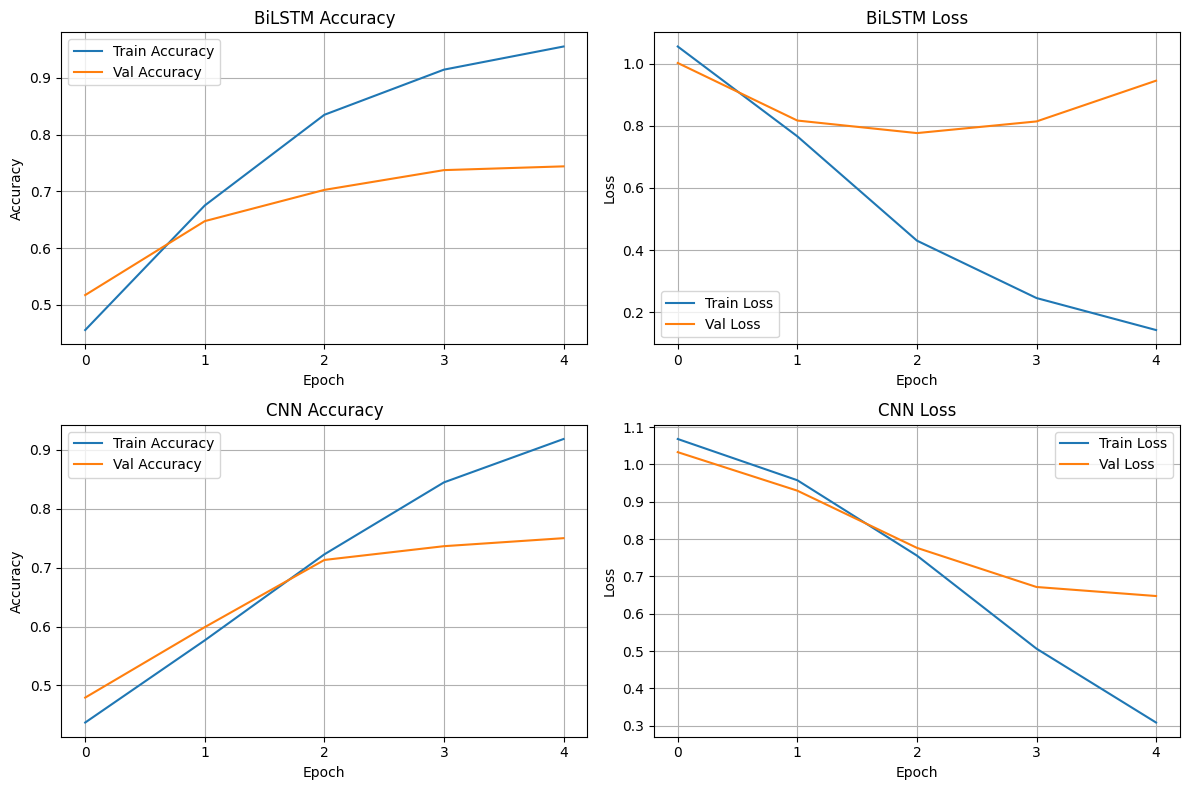

In [ ]:
# compare history_bi vs. history_cnn (training curves & metrics).

# 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax in axs.flat:
    ax.xaxis.set_major_locator(MultipleLocator(1))

# BiLSTM Accuracy (Top Left)
axs[0, 0].plot(history_bi1.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history_bi1.history['val_accuracy'], label='Val Accuracy')
axs[0, 0].set_title('BiLSTM Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# BiLSTM Loss (Top Right)
axs[0, 1].plot(history_bi1.history['loss'], label='Train Loss')
axs[0, 1].plot(history_bi1.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('BiLSTM Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# CNN Accuracy (Bottom Left)
axs[1, 0].plot(history_cnn1.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_cnn1.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('CNN Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# CNN Loss (Bottom Right)
axs[1, 1].plot(history_cnn1.history['loss'], label='Train Loss')
axs[1, 1].plot(history_cnn1.history['val_loss'], label='Val Loss')
axs[1, 1].set_title('CNN Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

Analysis on the loss graphs:
- BiLSTM begins overfitting around epoch 2. (val increases, train decreases)
- CNN begins overfitting around epoch 3. (val increases, train decreases)

Analysis on the accuracy graphs:
- Both BiLSTM and CNN show similar training accuracy curve, reaching 1.
- CNN has slightly higher val accuracy than BiLSTML, better generalization.

Test accuracy

In [ ]:
print(f"BiLSTM test accuracy score: {history_bi1.history['val_accuracy'][-1] * 100:.2f}%")
print(f"CNN test accuracy score: {history_cnn1.history['val_accuracy'][-1] * 100:.2f}%")


BiLSTM test accuracy score: 73.26%
CNN test accuracy score: 74.65%


## Experiment 2

- In the second experiment, we label each lyrics with VADER to get the sentiment score. Then, we convert lyrics into fixed-size lists of numbers. We then build DL model to predict the newly column of lexicon score (sentiment score).

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Compute compound score for each lyric
combined_spotify_df['lexicon_score'] = combined_spotify_df['preprocessed_lyrics'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Map compound scores to 3 classes: 0=Negative, 1=Neutral, 2=Positive
def lex_label(comp):
    if comp >= 0.05:
        return 2      # Positive
    elif comp <= -0.05:
        return 0      # Negative
    else:
        return 1      # Neutral

combined_spotify_df['lexicon_label'] = combined_spotify_df['lexicon_score'].apply(lex_label)
print("Lexicon label distribution:\n", combined_spotify_df['lexicon_label'].value_counts())

Lexicon label distribution:
 lexicon_label
2    9267
0    4836
1     234
Name: count, dtype: int64


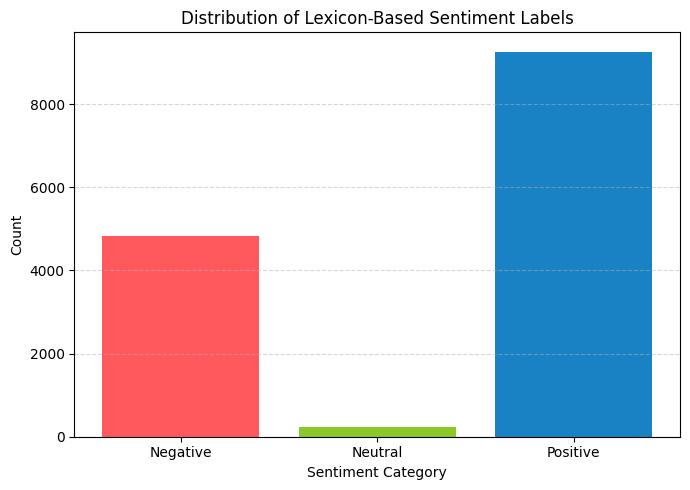

In [ ]:
import matplotlib.pyplot as plt

# Get value counts for lexicon-based labels (sorted by label)
lexicon_counts = combined_spotify_df['lexicon_label'].value_counts().sort_index()

# Map: 0 = Negative, 1 = Neutral, 2 = Positive
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
categories = [label_map[idx] for idx in lexicon_counts.index]
values = lexicon_counts.values

# Plot
plt.figure(figsize=(7, 5))
plt.bar(categories, values, color=['#FF595E', '#8AC926', '#1982C4'])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Distribution of Lexicon-Based Sentiment Labels')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
X = combined_spotify_df['preprocessed_lyrics'].tolist()
y = combined_spotify_df['lexicon_label'].values

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# TextVectorization & sequence preparation
max_vocab_size = 20000
max_seq_len    = 100

vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_seq_len
)
vectorizer.adapt(X_train)

# Convert texts to integer sequences
X_train_seq = vectorizer(np.array([[s] for s in X_train])).numpy().squeeze()
X_val_seq   = vectorizer(np.array([[s] for s in X_val])).numpy().squeeze()

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 20000


In [ ]:
# Build & train BiLSTM
embedding_dim = 128

bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_bi2 = bilstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=128
)

print(bilstm.summary())

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6265 - loss: 0.7973 - val_accuracy: 0.7967 - val_loss: 0.4989
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8545 - loss: 0.3892 - val_accuracy: 0.8483 - val_loss: 0.4100
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9237 - loss: 0.2365 - val_accuracy: 0.8574 - val_loss: 0.4181
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9546 - loss: 0.1462 - val_accuracy: 0.8598 - val_loss: 0.4403
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9642 - loss: 0.1140 - val_accuracy: 0.8672 - val_loss: 0.4999


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,819 (32.32 MB)

 Trainable params: 2,823,939 (10.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,647,880 (21.54 MB)

None


In [ ]:
# Build & train 1D-CNN
cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_cnn2 = cnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=128
)

print(cnn.summary())

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6338 - loss: 0.8257 - val_accuracy: 0.6977 - val_loss: 0.6195
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7523 - loss: 0.5721 - val_accuracy: 0.8312 - val_loss: 0.4551
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8762 - loss: 0.3650 - val_accuracy: 0.8644 - val_loss: 0.3690
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9365 - loss: 0.2083 - val_accuracy: 0.8672 - val_loss: 0.3490
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9663 - loss: 0.1210 - val_accuracy: 0.8759 - val_loss: 0.3637


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,927,307 (30.24 MB)

 Trainable params: 2,642,435 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,284,872 (20.16 MB)

None


### Evaluation on Experiment 2

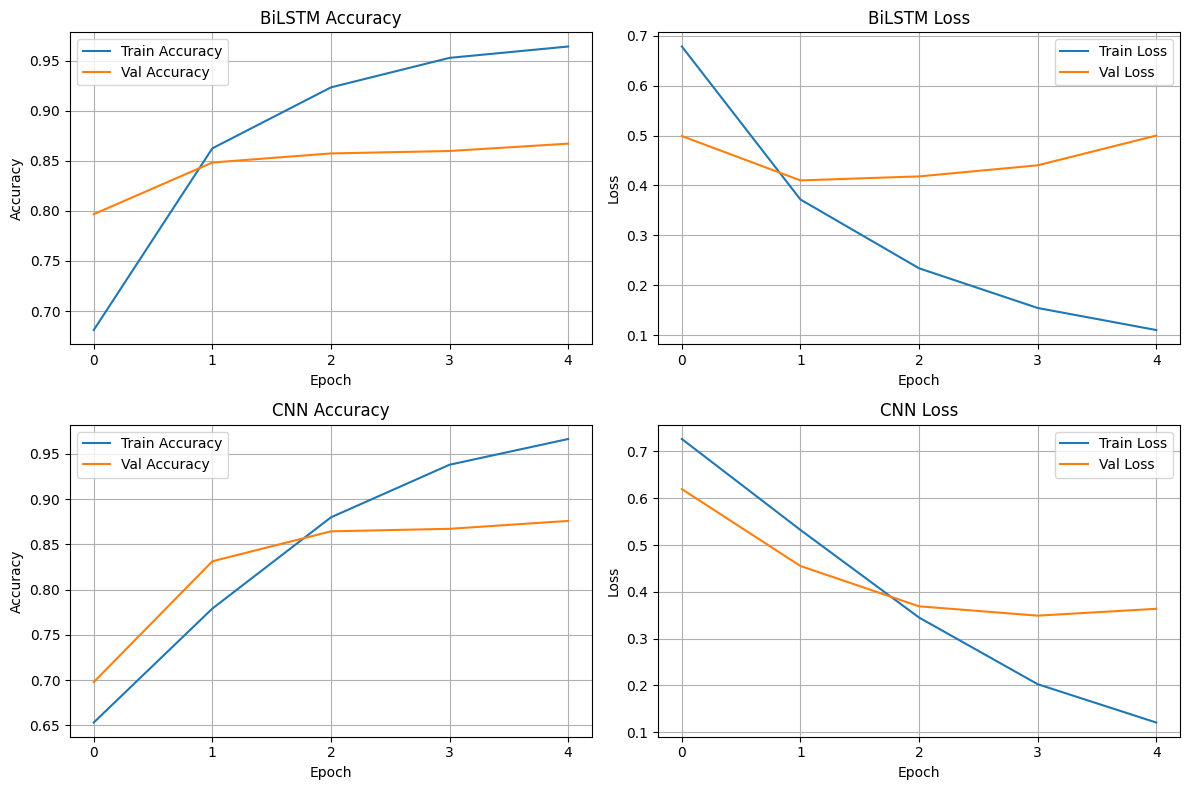

In [ ]:
# compare history_bi vs. history_cnn (training curves & metrics).

# 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax in axs.flat:
    ax.xaxis.set_major_locator(MultipleLocator(1))

# BiLSTM Accuracy (Top Left)
axs[0, 0].plot(history_bi2.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history_bi2.history['val_accuracy'], label='Val Accuracy')
axs[0, 0].set_title('BiLSTM Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# BiLSTM Loss (Top Right)
axs[0, 1].plot(history_bi2.history['loss'], label='Train Loss')
axs[0, 1].plot(history_bi2.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('BiLSTM Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# CNN Accuracy (Bottom Left)
axs[1, 0].plot(history_cnn2.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_cnn2.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('CNN Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# CNN Loss (Bottom Right)
axs[1, 1].plot(history_cnn2.history['loss'], label='Train Loss')
axs[1, 1].plot(history_cnn2.history['val_loss'], label='Val Loss')
axs[1, 1].set_title('CNN Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


Analysis on the loss graphs:
- BiLSTM starts overfitting around epoch 3 (val loss increases while train loss decreases).
- CNN shows less overfitting, with val loss stabilizing after epoch 3.

Analysis on the accuracy graphs:
- Both BiLSTM and CNN show steady improvement in train accuracy across epochs.
- CNN achieves slightly better validation accuracy than BiLSTM, indicating better generalization.

Test accuracy

In [ ]:
print(f"BiLSTM test accuracy score: {history_bi2.history['val_accuracy'][-1] * 100:.2f}%")
print(f"CNN test accuracy score: {history_cnn2.history['val_accuracy'][-1] * 100:.2f}%")

BiLSTM test accuracy score: 86.72%
CNN test accuracy score: 87.59%


## Experiment 3

- Using TFIDF to predict lexicon label.

In [ ]:
# Split data
X = combined_spotify_df['preprocessed_lyrics'].tolist()
y = combined_spotify_df['lexicon_label'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute TF-IDF features
max_vocab_size = 20000
tfidf = TfidfVectorizer(max_features=max_vocab_size)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_val_tfidf = tfidf.transform(X_val).toarray()


## Experiment 3.1

In [ ]:
# 3A. CNN on TF-IDF “sequence” (reshaped to [vocab,1])
cnn = Sequential([
    Reshape((max_vocab_size, 1), input_shape=(max_vocab_size,)),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history_cnn3 = cnn.fit(
    X_train_tfidf, y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=5, batch_size=128
)
print(cnn.summary())

# 3B. Feed-forward “dense” net (in lieu of a BiLSTM)
inp = Input(shape=(max_vocab_size,))
x = Dropout(0.5)(inp)
x = Dense(128, activation='relu')(x)
out = Dense(3,   activation='softmax')(x)
dense_model = Model(inp, out)
dense_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history_dn = dense_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=5, batch_size=128
)
print(dense_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 292ms/step - accuracy: 0.5502 - loss: 0.9658 - val_accuracy: 0.6464 - val_loss: 0.7438
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.6457 - loss: 0.7402 - val_accuracy: 0.6464 - val_loss: 0.7217
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.6452 - loss: 0.7262 - val_accuracy: 0.6464 - val_loss: 0.7205
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.6520 - loss: 0.7282 - val_accuracy: 0.6464 - val_loss: 0.7200
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.6426 - loss: 0.7263 - val_accuracy: 0.6464 - val_loss: 0.7209


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 20000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 19996, 128)     │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,467 (13.55 KB)

 Trainable params: 1,155 (4.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,312 (9.04 KB)

None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6227 - loss: 0.8939 - val_accuracy: 0.7165 - val_loss: 0.5974
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7637 - loss: 0.5554 - val_accuracy: 0.8173 - val_loss: 0.4747
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8321 - loss: 0.4347 - val_accuracy: 0.8337 - val_loss: 0.4318
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8453 - loss: 0.3816 - val_accuracy: 0.8466 - val_loss: 0.4041
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8649 - loss: 0.3405 - val_accuracy: 0.8480 - val_loss: 0.3934


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681,547 (29.30 MB)

 Trainable params: 2,560,515 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,121,032 (19.54 MB)

None


### Evaluation on Experiment 3.1

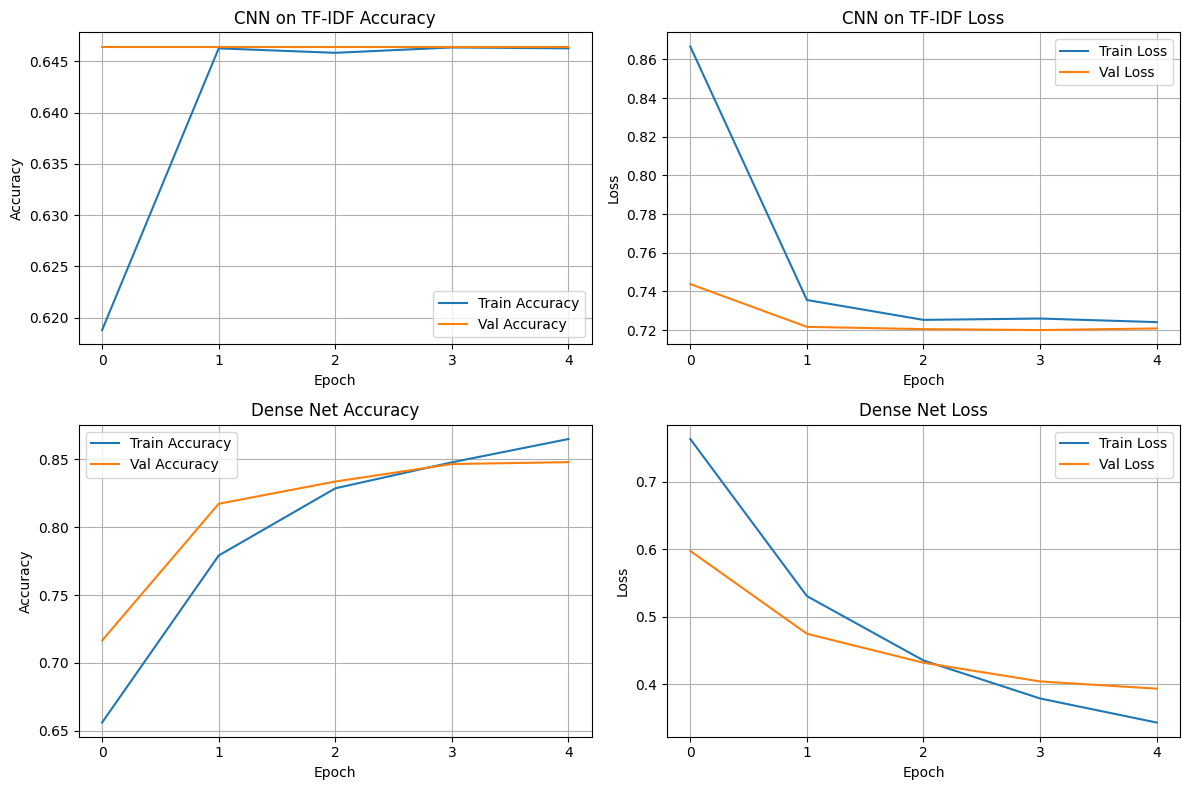

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax in axs.flat:
    ax.xaxis.set_major_locator(MultipleLocator(1))

# CNN Accuracy (Top Left)
axs[0, 0].plot(history_cnn3.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history_cnn3.history['val_accuracy'], label='Val Accuracy')
axs[0, 0].set_title('CNN on TF-IDF Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# CNN Loss (Top Right)
axs[0, 1].plot(history_cnn3.history['loss'], label='Train Loss')
axs[0, 1].plot(history_cnn3.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('CNN on TF-IDF Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Dense Accuracy (Bottom Left)
axs[1, 0].plot(history_dn.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_dn.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('Dense Net Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Dense Loss (Bottom Right)
axs[1, 1].plot(history_dn.history['loss'], label='Train Loss')
axs[1, 1].plot(history_dn.history['val_loss'], label='Val Loss')
axs[1, 1].set_title('Dense Net Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(f"CNN on TF-IDF test accuracy score: {history_cnn3.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Feed-forward Dense Net test accuracy score: {history_dn.history['val_accuracy'][-1] * 100:.2f}%")

CNN on TF-IDF test accuracy score: 64.64%
Feed-forward Dense Net test accuracy score: 84.80%


## Experiment 3.2
- ML with TFIDF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_val_tfidf)
print("Random Forest:\n", classification_report(y_val, y_pred_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, tree_method="hist", use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_val_tfidf)
print("XGBoost:\n", classification_report(y_val, y_pred_xgb))


Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.69      0.81       967
           1       0.77      0.64      0.70        47
           2       0.86      0.98      0.92      1854

    accuracy                           0.88      2868
   macro avg       0.86      0.77      0.81      2868
weighted avg       0.89      0.88      0.88      2868



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83       967
           1       0.92      0.51      0.66        47
           2       0.88      0.96      0.92      1854

    accuracy                           0.89      2868
   macro avg       0.90      0.74      0.80      2868
weighted avg       0.89      0.89      0.88      2868



## Experiment 4
- In this experiment, we build DistilBERT, a Transformer architecture-based model to predict sentiment score.

In [ ]:
# lexicon_label contains 0, 1, 2
# 0 => negative, 1 => neutral, 2 => positive
X = combined_spotify_df["preprocessed_lyrics"].astype(str)
y = combined_spotify_df["lexicon_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Load BERT tokenizer
tokenizer1 = BertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer2 = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Tokenize input
train_encodings = tokenizer1(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer1(list(X_test), truncation=True, padding=True, max_length=512)
train_encodings = tokenizer2(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer2(list(X_test), truncation=True, padding=True, max_length=512)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# Create torch dataset to fit into the model
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels.iloc[idx])}

train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset = SentimentDataset(test_encodings, y_test)

In [ ]:
# Model with 3 output labels
distilBertModel = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
miniBertModel = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name="bert_sentiment_classification",
    report_to=None
)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted")
    }

In [ ]:
# turn off the external UI dashboard
os.environ["WANDB_DISABLED"] = "true"

DistilBERT = Trainer(
    model=distilBertModel,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
DistilBERT.train()

Epoch,Training Loss,Validation Loss


In [ ]:
MIniBERT = Trainer(
    model=miniBertModel,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
MIniBERT.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.032900,1.040592,0.466527,0.460623,0.466527,0.398632
2,1.044600,1.022197,0.495467,0.488898,0.495467,0.457405
3,0.963000,1.009113,0.506974,0.500454,0.506974,0.463422
4,0.950500,0.997893,0.513947,0.495093,0.513947,0.482861
5,0.956900,0.991735,0.519526,0.500606,0.519526,0.488562


TrainOutput(global_step=1795, training_loss=0.9751049525226391, metrics={'train_runtime': 100.3069, 'train_samples_per_second': 571.695, 'train_steps_per_second': 17.895, 'total_flos': 72878804444160.0, 'train_loss': 0.9751049525226391, 'epoch': 5.0})

### Evaluation on Experiment 4

In [ ]:
eval_result1 = DistilBERT.evaluate()

print(f"Evaluation Results at Epoch {eval_result1['epoch']:.0f}:")
print(f"Loss      : {eval_result1['eval_loss']:.4f}")
print(f"Accuracy  : {eval_result1['eval_accuracy'] * 100:.2f}%")
print(f"Precision : {eval_result1['eval_precision'] * 100:.2f}%")
print(f"Recall    : {eval_result1['eval_recall'] * 100:.2f}%")
print(f"F1 Score  : {eval_result1['eval_f1'] * 100:.2f}%")

Evaluation Results at Epoch 5:
Loss      : 1.0440
Accuracy  : 46.76%
Precision : 35.81%
Recall    : 46.76%
F1 Score  : 39.11%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
eval_result2 = MIniBERT.evaluate()

print(f"Evaluation Results at Epoch {eval_result2['epoch']:.0f}:")
print(f"Loss      : {eval_result2['eval_loss']:.4f}")
print(f"Accuracy  : {eval_result2['eval_accuracy'] * 100:.2f}%")
print(f"Precision : {eval_result2['eval_precision'] * 100:.2f}%")
print(f"Recall    : {eval_result2['eval_recall'] * 100:.2f}%")
print(f"F1 Score  : {eval_result2['eval_f1'] * 100:.2f}%")

Evaluation Results at Epoch 5:
Loss      : 0.9917
Accuracy  : 51.95%
Precision : 50.06%
Recall    : 51.95%
F1 Score  : 48.86%


## Experiment 5
- We use DistilBert to generate embeddings (continuous vectors ) from preprocessed lyrics

## Experiment 5.1
- Feeding DL models the embeddings to predict lexicon label

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model = model.to('cuda')
model.eval()

def batch_bert_embeddings(text_list, tokenizer, model, batch_size=32, max_length=128):
    all_embeddings = []
    rows_done = 0
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.cpu().numpy()
            all_embeddings.append(batch_embeddings)
        rows_done += len(batch)
        if rows_done % 200 == 0 or rows_done >= len(text_list):
            print(f"{rows_done} rows processed")
    return np.vstack(all_embeddings)

text_list = combined_spotify_df['preprocessed_lyrics'].astype(str).tolist()
X_bert = batch_bert_embeddings(text_list, tokenizer, model, batch_size=64)

print("Embedding shape:", X_bert.shape)

 11%|█         | 25/225 [00:08<01:07,  2.96it/s]

1600 rows processed


 22%|██▏       | 50/225 [00:17<00:59,  2.94it/s]

3200 rows processed


 33%|███▎      | 75/225 [00:27<01:10,  2.12it/s]

4800 rows processed


 44%|████▍     | 100/225 [00:37<00:44,  2.82it/s]

6400 rows processed


 56%|█████▌    | 125/225 [00:47<00:38,  2.61it/s]

8000 rows processed


 67%|██████▋   | 150/225 [00:55<00:27,  2.73it/s]

9600 rows processed


 78%|███████▊  | 175/225 [01:05<00:19,  2.61it/s]

11200 rows processed


 89%|████████▉ | 200/225 [01:16<00:11,  2.22it/s]

12800 rows processed


100%|██████████| 225/225 [01:26<00:00,  2.59it/s]


14337 rows processed
Embedding shape: (14337, 128, 768)


In [ ]:
# Split data
y = combined_spotify_df['lexicon_label'].values
X_train, X_val, y_train, y_val = train_test_split(
    X_bert, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Train BiLSTM
max_seq_len = X_bert.shape[1]
feature_dim = X_bert.shape[2]

bilstm = Sequential([
    InputLayer(input_shape=(max_seq_len, feature_dim)),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history_bi4 = bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)
print(bilstm.summary())

c:\Users\Acer\anaconda3\envs\ML_VIP_env\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 561ms/step - accuracy: 0.6327 - loss: 0.7233 - val_accuracy: 0.7437 - val_loss: 0.5570
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 494ms/step - accuracy: 0.7334 - loss: 0.5624 - val_accuracy: 0.7570 - val_loss: 0.5267
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 483ms/step - accuracy: 0.7548 - loss: 0.5274 - val_accuracy: 0.7420 - val_loss: 0.5421
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.7810 - loss: 0.4901 - val_accuracy: 0.7877 - val_loss: 0.4835
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 499ms/step - accuracy: 0.8145 - loss: 0.4350 - val_accuracy: 0.7908 - val_loss: 0.4635


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757,899 (10.52 MB)

 Trainable params: 919,299 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,838,600 (7.01 MB)

None


In [ ]:
# Train CNN
max_seq_len = X_bert.shape[1]
feature_dim = X_bert.shape[2]

cnn = Sequential([
    InputLayer(input_shape=(max_seq_len, 768)),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history_cnn4 = cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)
print(cnn.summary())

c:\Users\Acer\anaconda3\envs\ML_VIP_env\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 366ms/step - accuracy: 0.5989 - loss: 1.1005 - val_accuracy: 0.7587 - val_loss: 0.5344
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.7422 - loss: 0.5600 - val_accuracy: 0.7744 - val_loss: 0.4983
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.7935 - loss: 0.4790 - val_accuracy: 0.7856 - val_loss: 0.4762
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.8182 - loss: 0.4400 - val_accuracy: 0.8260 - val_loss: 0.4361
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 192ms/step - accuracy: 0.8391 - loss: 0.4016 - val_accuracy: 0.8421 - val_loss: 0.4074


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 124, 128)       │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,476,107 (5.63 MB)

 Trainable params: 492,035 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984,072 (3.75 MB)

None


### Evaluation on Experiment 5.1

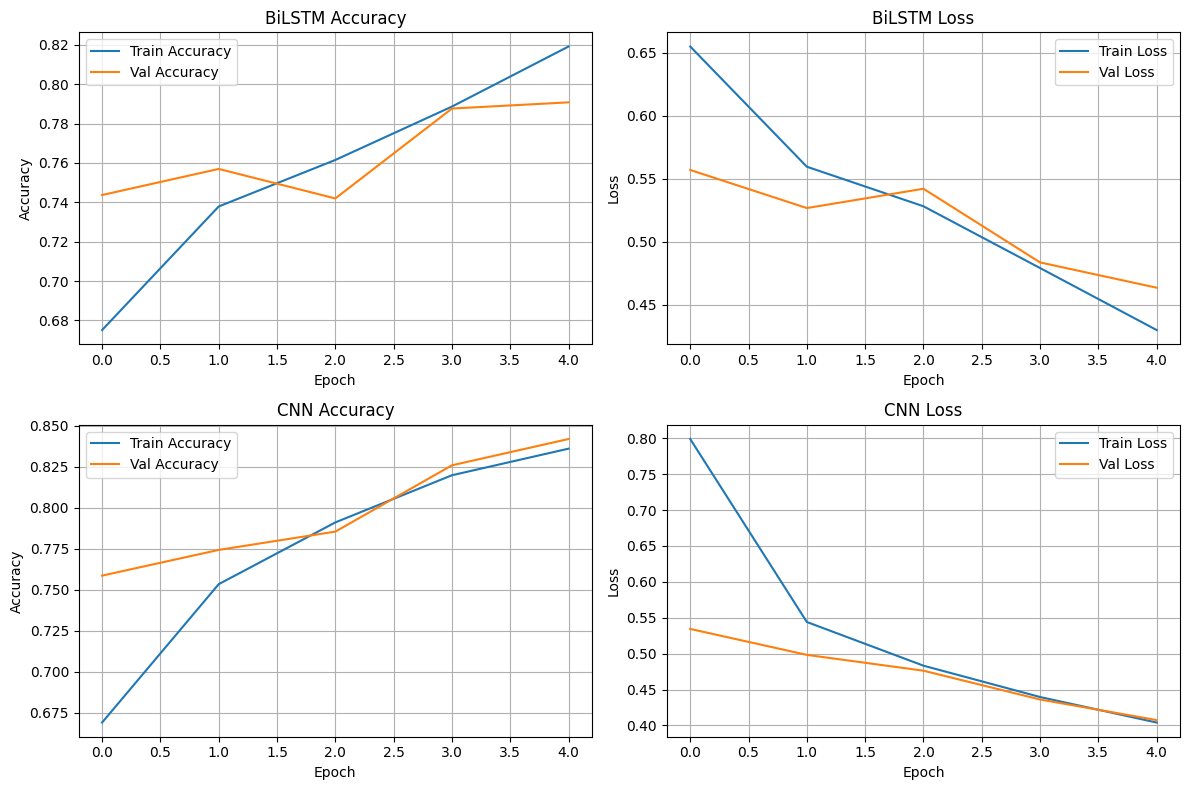

In [ ]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(history_bi4.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history_bi4.history['val_accuracy'], label='Val Accuracy')
axs[0, 0].set_title('BiLSTM Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(history_bi4.history['loss'], label='Train Loss')
axs[0, 1].plot(history_bi4.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('BiLSTM Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(history_cnn4.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_cnn4.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('CNN Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(history_cnn4.history['loss'], label='Train Loss')
axs[1, 1].plot(history_cnn4.history['val_loss'], label='Val Loss')
axs[1, 1].set_title('CNN Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(f"BiLSTM test accuracy score: {history_bi4.history['val_accuracy'][-1] * 100:.2f}%")
print(f"CNN test accuracy score: {history_cnn4.history['val_accuracy'][-1] * 100:.2f}%")

BiLSTM test accuracy score: 79.08%
CNN test accuracy score: 84.21%


## Experiment 5.2
- Feeding ML models the embeddings to predict lexicon label

In [ ]:
# Pool BERT embeddings
X_bert_mean = X_bert.mean(axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_bert_mean, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Random Forest:\n", classification_report(y_val, y_pred_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, tree_method="hist")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
print("XGBoost:\n", classification_report(y_val, y_pred_xgb))

Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.72      0.81       967
           1       1.00      0.43      0.60        47
           2       0.86      0.97      0.91      1854

    accuracy                           0.88      2868
   macro avg       0.93      0.71      0.78      2868
weighted avg       0.89      0.88      0.88      2868

XGBoost:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       967
           1       0.88      0.49      0.63        47
           2       0.89      0.95      0.92      1854

    accuracy                           0.89      2868
   macro avg       0.88      0.74      0.79      2868
weighted avg       0.89      0.89      0.88      2868



# Visualization and Insight Generation

### WordCloud
- We use WordCloud to visualize the frequency of words in the preprocessed lyrics to get a quick understanding of the lyrical contents.

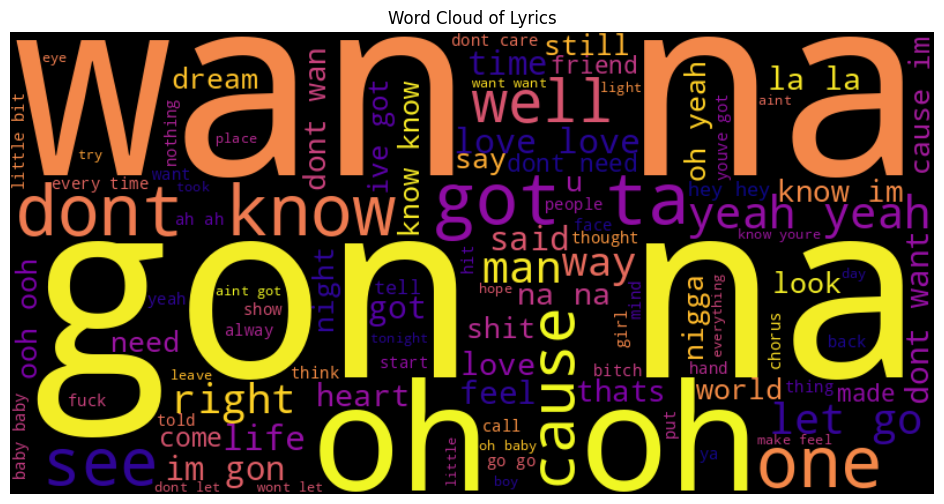

In [ ]:
from wordcloud import WordCloud

text = " ".join(combined_spotify_df['preprocessed_lyrics'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100, colormap='plasma').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lyrics')
plt.show()

In [ ]:
import spacy
from textblob import TextBlob

# load spacy
texts = combined_spotify_df["preprocessed_lyrics"].astype(str).tolist()
nlp = spacy.load("en_core_web_sm")

#ABSA
def aspect_sentiments(doc):
    aspect_sents = []
    for sent in doc.sents:
        blob = TextBlob(sent.text)
        for nc in sent.noun_chunks:
            aspect_sents.append((nc.text, blob.sentiment.polarity))
    return aspect_sents

results = []
for txt in texts:
    doc = nlp(txt)
    absas = aspect_sentiments(doc)
    results.append({
        "lyrics": txt,
        "aspect_sentiments": absas
    })

out_df = pd.DataFrame(results)
print(out_df.head(5))

                                              lyrics  \
0  little bird little bird fly window little bird...   
1  ive got friend baltimore little liza jane stre...   
2  who pretty baby who pretty little baby youre p...   
3  go sleep go sleep go sleep little sleep eye go...   
4  word lip took granted want skinny dip quick hi...   

                                   aspect_sentiments  
0  [(window, 0.20750000000000002), (window, 0.207...  
1  [(i, -0.1875), (door, -0.1875), (oh little liz...  
2  [(who, 0.075), (who, 0.075), (you, 0.075), (pr...  
3  [(sleep, -0.17578125), (little sleep eye, -0.1...  
4  [(word lip, -0.033333333333333354), (skinny di...  


### Aspect-Wise Sentiment Maps

In [ ]:
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd
from collections import defaultdict
from nltk.corpus import stopwords

# Downloads nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load models
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Extract noun chunks (aspects)
def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text.split()) <= 3]

combined_spotify_df['aspects'] = combined_spotify_df['preprocessed_lyrics'].apply(extract_aspects)

# Calculate sentiment scores for each aspect using VADER
def aspect_sentiment_score(aspects):
    scores = {}
    for asp in aspects:
        compound = sia.polarity_scores(asp)['compound']
        scores[asp] = compound
    return scores

combined_spotify_df['aspect_sentiment'] = combined_spotify_df['aspects'].apply(aspect_sentiment_score)

# Group by root keywords using lemmatization
def clean_aspect_phrase(phrase):
    doc = nlp(phrase)
    keywords = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_.lower() not in stop_words
    ]
    return keywords

# Make a dictionary to store keyword:score
keyword_sentiment = defaultdict(list)

for aspect_dict in combined_spotify_df['aspect_sentiment']:
    for phrase, score in aspect_dict.items():
        keywords = clean_aspect_phrase(phrase)
        for keyword in keywords:
            keyword_sentiment[keyword].append(score)

# Average sentiment scores for each keyword
keyword_sent_df = pd.DataFrame([
    {'keyword': k, 'sentiment': sum(v)/len(v), 'count': len(v)}
    for k, v in keyword_sentiment.items()
])

# Filter out keywords with low frequency
keyword_sent_df = keyword_sent_df[keyword_sent_df['count'] >= 10]

# Get top/bottom keywords
top_keywords = keyword_sent_df.sort_values(by='sentiment', ascending=False).head(15)
bottom_keywords = keyword_sent_df.sort_values(by='sentiment', ascending=True).head(15)
keyword_top_bottom = pd.concat([top_keywords, bottom_keywords])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipython-input-18-1385069743.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=keyword_top_bottom, x='sentiment', y='keyword', palette='coolwarm')


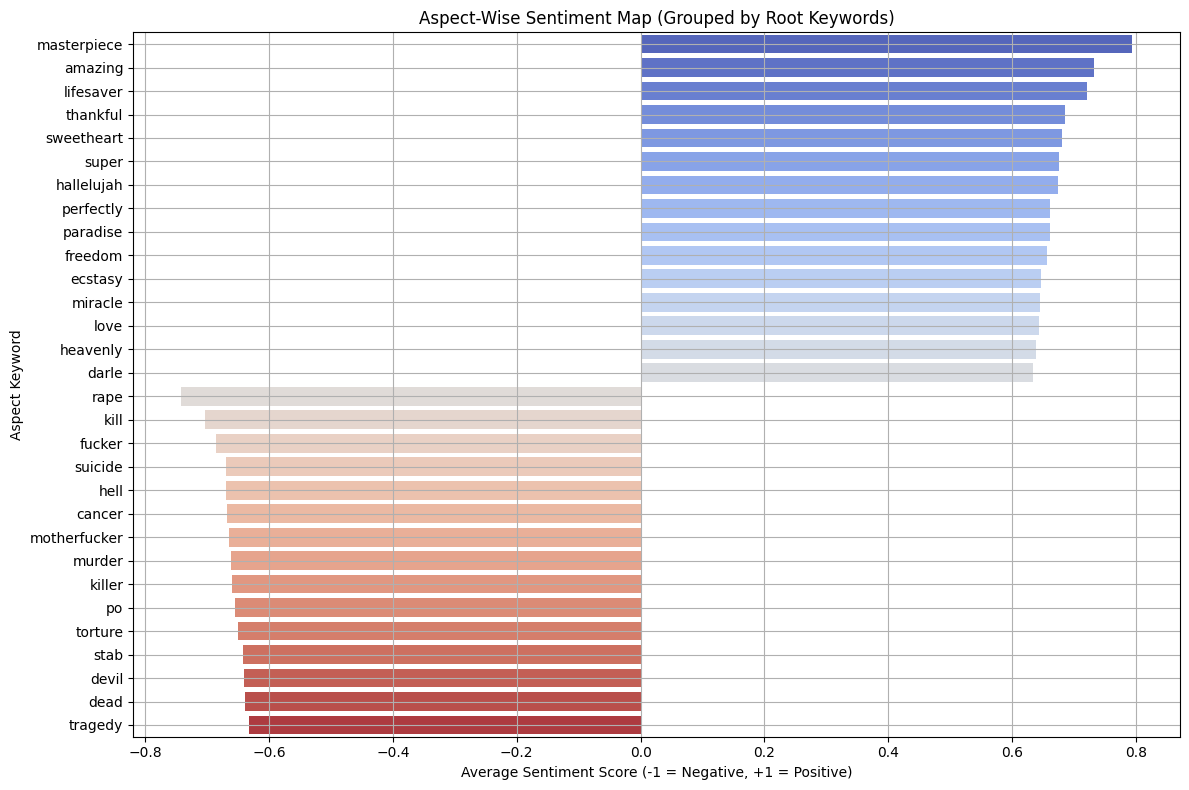

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=keyword_top_bottom, x='sentiment', y='keyword', palette='coolwarm')
plt.title("Aspect-Wise Sentiment Map (Grouped by Root Keywords)")
plt.xlabel("Average Sentiment Score (-1 = Negative, +1 = Positive)")
plt.ylabel("Aspect Keyword")
plt.grid(True)
plt.tight_layout()
plt.show()